https://archive.ics.uci.edu/ml/datasets/UJIIndoorLoc

"The 529 attributes contain the WiFi fingerprint, the coordinates where it was taken, and other useful information.

Each WiFi fingerprint can be characterized by the detected Wireless Access Points (WAPs) and the corresponding Received Signal Strength Intensity (RSSI). The intensity values are represented as negative integer values ranging -104dBm (extremely poor signal) to 0dbM. The positive value 100 is used to denote when a WAP was not detected. During the database creation, 520 different WAPs were detected. Thus, the WiFi fingerprint is composed by 520 intensity values.

Then the coordinates (latitude, longitude, floor) and Building ID are provided as the attributes to be predicted.

Additional information has been provided.

The particular space (offices, labs, etc.) and the relative position (inside/outside the space) where the capture was taken have been recorded. Outside means that the capture was taken in front of the door of the space.

Information about who (user), how (android device & version) and when (timestamp) WiFi capture was taken is also recorded. "

Can use regression to get lat/long or classification to predict building/floor

For this exercise, we will use classification to predict building/floor

# 0. Imports

In [ ]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import neighbors
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# 1. Load Dataset

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/mltotem/building-floor-using-WAP-RSSI/master/UJIndoorLOC/trainingData.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/mltotem/building-floor-using-WAP-RSSI/master/UJIndoorLOC/validationData.csv')

# 2. Preview / Pre-processing

In [ ]:
df.describe()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,WAP013,WAP014,WAP015,WAP016,WAP017,WAP018,WAP019,WAP020,WAP021,WAP022,WAP023,WAP024,WAP025,WAP026,WAP027,WAP028,WAP029,WAP030,WAP031,WAP032,WAP033,WAP034,WAP035,WAP036,WAP037,WAP038,WAP039,WAP040,...,WAP490,WAP491,WAP492,WAP493,WAP494,WAP495,WAP496,WAP497,WAP498,WAP499,WAP500,WAP501,WAP502,WAP503,WAP504,WAP505,WAP506,WAP507,WAP508,WAP509,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,19937.000000,19937.000000,19937.0,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,...,19937.000000,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.0,19937.000000,1.993700e+04,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,1.993700e+04
mean,99.823644,99.820936,100.0,100.0,99.613733,97.130461,94.733661,93.820234,94.693936,99.163766,74.144606,73.899182,82.795606,82.959372,90.617144,90.627075,99.199980,99.154988,96.326529,96.577168,99.639565,99.640066,93.044239,92.999649,94.373677,94.154386,93.043136,92.785223,86.829914,86.330491,94.677685,94.687114,86.461454,86.512264,83.697196,83.694989,92.220745,93.604655,87.036565,86.731103,...,99.884386,100.0,98.956814,98.899182,99.079500,72.728545,57.995436,100.0,98.909465,98.822240,99.019812,70.857802,58.966846,83.426995,99.365953,99.981442,99.705021,99.980338,99.115313,99.943372,99.990119,84.974921,99.866881,98.881276,98.833325,99.436525,73.705673,59.889803,99.788634,99.970507,100.0,-7464.275947,4.864871e+06,1.674575,1.212820,148.429954,1.833024,9.068014,13.021869,1.371421e+09
std,5.866842,5.798156,0.0,0.0,8.615657,22.931890,30.541335,33.010404,30.305084,12.634045,62.182586,62.442166,52.005624,51.803007,40.711249,40.832376,12.301962,12.621951,25.142380,24.272157,8.359643,8.348003,34.559630,34.664154,31.181223,31.773437,34.531143,35.109838,45.940359,46.821541,30.087370,30.027574,46.513779,46.418554,50.700623,50.734245,36.648323,33.349681,45.515553,46.055288,...,4.711652,0.0,13.701929,14.211409,13.099782,63.319197,75.334826,0.0,14.020779,14.715204,13.539838,65.003736,74.736672,52.338958,10.921143,1.852874,7.476381,1.963071,12.994215,3.264807,1.395200,50.099899,5.023663,14.206023,14.634613,10.259137,62.278292,74.060259,6.360671,2.404232,0.0,123.402010,6.693318e+01,1.223078,0.833139,58.342106,0.372964,4.988720,5.362410,5.572054e+05
min,-97.000000,-90.000000,100.0,100.0,-97.000000,-98.000000,-99.000000,-98.000000,-98.000000,-99.000000,-101.000000,-101.000000,-98.000000,-98.000000,-101.000000,-99.000000,-98.000000,-98.000000,-99.000000,-99.000000,-98.000000,-98.000000,-100.000000,-99.000000,-98.000000,-98.000000,-99.000000,-98.000000,-98.000000,-99.000000,-99.000000,-101.000000,-98.000000,-98.000000,-100.000000,-98.000000,-99.000000,-98.000000,-100.000000,-98.000000,...,-96.000000,100.0,-90.000000,-91.000000,-97.000000,-100.000000,-101.000000,100.0,-90.000000,-91.000000,-97.000000,-101.000000,-97.000000,-102.000000,-99.000000,-85.000000,-97.000000,-97.000000,-97.000000,-98.000000,-97.000000,-103.000000,-97.000000,-92.000000,-90.000000,-97.000000,-101.000000,-101.000000,-97.000000,-97.000000,100.0,-7691.338400,4.864746e+06,0.000000,0.000000,1.00

In [ ]:
df.columns

Index(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006', 'WAP007',
       'WAP008', 'WAP009', 'WAP010',
       ...
       'WAP520', 'LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID',
       'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP'],
      dtype='object', length=529)

Check data for na

In [ ]:
df.isna().sum().sum()

0

## Define columns for features / output

In [ ]:
columns_to_drop = ['LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID',
                   'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP']                 

In [ ]:
X_train = df.drop(columns_to_drop,axis=1)

In [ ]:
y_train = df['BUILDINGID']

# 3. Training - Boost Model

Define Gradient Boost Model function

In [ ]:
def boost_model(X, y, n_estimators=100, depth=3, learning_rate=0.1, subsample=1.0):

  params = {'n_estimators': n_estimators,
            'max_depth': depth,
            'loss': 'deviance',
            'learning_rate': learning_rate,
            'subsample':subsample}

  # Initialize and fit the model.
  clf = ensemble.GradientBoostingClassifier(**params)
  clf.fit(X, y)
  score = clf.score(X,y)
  print('  score:',score)

  return clf, score

## Predict building ID only

In [ ]:
# classify by buildingID
bldgID_clf = boost_model(X_train, y_train)

score: 0.9980438380899834


99.8% accuracy in predicting the building

Let's also predict building and floor

## Predict Building and Floor

Determine # of floors per building, then "stack" the floors from all the buildings

In [ ]:
for building in df['BUILDINGID'].unique():
  print('building',building,':', df[df['BUILDINGID'] == building]['FLOOR'].unique() )

building 1 : [2 0 1 3]
building 0 : [0 2 1 3]
building 2 : [3 2 4 1 0]


Create feature 'BLDG_FLOOR' by stacking the floors from all the buildings

In [ ]:
df['BLDG_FLOOR'] = np.add(np.multiply(df['BUILDINGID'], 4), df['FLOOR'])
print(df['BLDG_FLOOR'].unique() )   # should be 0 - 12

[ 6  0 11 10 12  4  5  9  7  8  2  1  3]


In [ ]:
columns_to_drop.append('BLDG_FLOOR')

In [ ]:
X_train = df.drop(columns_to_drop,axis=1)
y_train = df['BLDG_FLOOR']
base_clf,_ = boost_model(X_train, y_train)

score: 0.9977930481015198


still 99.8%

### Vary boost model parameters

Vary depth

In [ ]:
n = 'ALL'
full_depth_scores = []
full_depth_models = []
depth = [2, 3, 4]

X_train = df.drop(columns_to_drop,axis=1)
y_train = df['BLDG_FLOOR']
for d in depth:
  print('Features: {}, depth: {}'.format(n, d))
  model, score = boost_model(X_train, y_train, depth=d)
  full_depth_scores.append(score)
  full_depth_models.append(model)

Features: ALL, depth: 2
score: 0.9912725084014646
Features: ALL, depth: 3
score: 0.9978432060992125
Features: ALL, depth: 4
score: 0.9980438380899834


Vary # of estimators

In [ ]:
# check performance # of estimators
n='ALL'
depth=5
full_est_scores = []
full_est_models = []
estimators = [50, 100, 200]

X_train = df.drop(columns_to_drop,axis=1)
y_train = df['BLDG_FLOOR']
for est in estimators:
  print('Features: {}, depth: {}, estimators: {}'.format(n, depth, est))
  model, score = boost_model(X_train, y_train, n_estimators=est, depth=depth)
  full_est_scores.append(score)
  full_est_models.append(model)

Features: ALL, depth: 5, estimators: 50
score: 0.9980438380899834
Features: ALL, depth: 5, estimators: 100
score: 0.9980438380899834
Features: ALL, depth: 5, estimators: 200
score: 0.9980438380899834


## Reduced number of features

Will reduce # of features to arbitrarily lower the model accuracy to see how learning rate, sub-sampling affects model performance

First, review feature importance on the base model that used all the features.

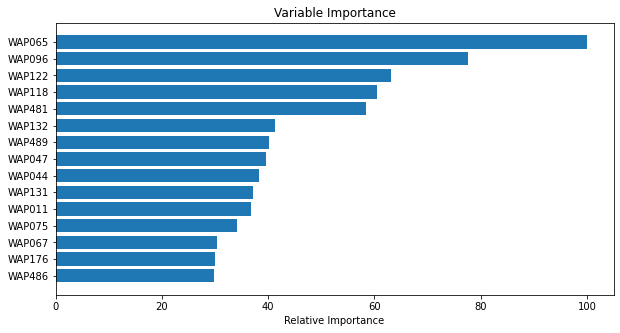

In [ ]:
feature_importances = base_clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importances / feature_importances.max())
sorted_idx_all = np.argsort(feature_importance)
sorted_idx = sorted_idx_all[-15:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,5))
#plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
# make graph of features trained on vs errors
scores = []
n_features = [15, 20, 30, 40, 50, 70, 100, 150, 200]

y_train = df['BLDG_FLOOR']
for n in n_features:
  X_train = df[df.columns[sorted_idx_all[-n:]]]
  print('Features:',n, end=', ')
  _, score = boost_model(X_train, y_train)

  scores.append(score)

Features: 15, score: 0.6592767216732708
Features: 20, score: 0.7243316446807443
Features: 30, score: 0.8672317801073381
Features: 40, score: 0.9060540703215128
Features: 50, score: 0.9557606460350103
Features: 70, score: 0.9774289010382705
Features: 100, score: 0.9941315142699504
Features: 150, score: 0.9975422581130561
Features: 200, score: 0.9976425741084416


Text(0, 0.5, 'Accuracy')

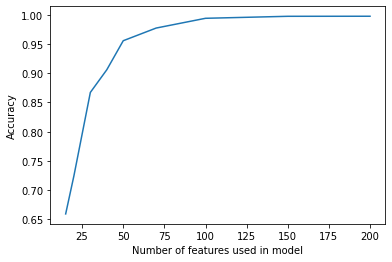

In [ ]:
# plot errors vs features for a fixed # of estinmators
plt.plot(n_features, scores)
plt.xlabel('Number of features used in model')
plt.ylabel('Accuracy')

In [ ]:
# change depth
n=50  # allows us to see effect of parameters on model performance
depth_scores = []
depth_models = []
depth = [2, 3, 4, 5, 6, 7]

X_train = df[df.columns[sorted_idx_all[-n:]]]
y_train = df['BLDG_FLOOR']
for d in depth:
  print('Features: {}, depth: {}'.format(n, d))
  model, score = boost_model(X_train, y_train, depth=d)
  depth_scores.append(score)
  depth_models.append(model)

Features: 50, depth: 2
score: 0.9362491849325375
Features: 50, depth: 3
score: 0.9557606460350103
Features: 50, depth: 4
score: 0.9675477754928024
Features: 50, depth: 5
score: 0.9717108893012991
Features: 50, depth: 6
score: 0.9728645232482319
Features: 50, depth: 7
score: 0.973215629232081


In [ ]:
# check performance # of estimators
n=50
depth=5
est_scores = []
est_models = []
estimators = [50, 100, 200, 300]

X_train = df[df.columns[sorted_idx_all[-n:]]]
y_train = df['BLDG_FLOOR']
for est in estimators:
  print('Features: {}, depth: {}, estimators: {}'.format(n, depth, est))
  model, score = boost_model(X_train, y_train, n_estimators=est, depth=depth)
  est_scores.append(score)
  est_models.append(model)

Features: 50, depth: 5, estimators: 50
score: 0.9641370316496966
Features: 50, depth: 5, estimators: 100
score: 0.9717108893012991
Features: 50, depth: 5, estimators: 200
score: 0.9731153132366956
Features: 50, depth: 5, estimators: 300
score: 0.9732657872297737


Vary the learning rate

In [ ]:
# check performance learning rate
n=50
depth=5
lr_scores = []
lr_models = []
learning_rates = [0.02, 0.05, 0.1, 0.2, 0.3]

X_train = df[df.columns[sorted_idx_all[-n:]]]
y_train = df['BLDG_FLOOR']
for rate in learning_rates:
  print('Features: {}, depth: {}, learning rate: {}'.format(n, depth, rate))
  model, score = boost_model(X_train, y_train, learning_rate=rate, depth=depth)
  lr_scores.append(score)
  lr_models.append(model)

Features: 50, depth: 5, learning rate: 0.02
score: 0.9462306264733912
Features: 50, depth: 5, learning rate: 0.05
score: 0.964036715654311
Features: 50, depth: 5, learning rate: 0.1
score: 0.9718112052966845
Features: 50, depth: 5, learning rate: 0.2
score: 0.973215629232081
Features: 50, depth: 5, learning rate: 0.3
score: 0.9729648392436174


Also, try sub-sampling

In [ ]:
# check performance sub-sampling
n=50
depth=5
sampling_scores = []
sampling_models = []
sub_samples = [0.4, 0.6, 0.8, 0.9, 1.0]

X_train = df[df.columns[sorted_idx_all[-n:]]]
y_train = df['BLDG_FLOOR']
for sample in sub_samples:
  print('Features: {}, depth: {}, subsamples: {}'.format(n, depth, sample))
  model, score = boost_model(X_train, y_train, subsample=sample, depth=depth)
  sampling_scores.append(score)
  sampling_models.append(model)

Features: 50, depth: 5, subsamples: 0.4
score: 0.9705572553543662
Features: 50, depth: 5, subsamples: 0.6
score: 0.9716105733059136
Features: 50, depth: 5, subsamples: 0.8
score: 0.9718112052966845
Features: 50, depth: 5, subsamples: 0.9
score: 0.9721623112805337
Features: 50, depth: 5, subsamples: 1.0
score: 0.9717108893012991


# 4. Training - other models

In [ ]:
# import classifier
n=50
from sklearn.svm import SVC

# use default kernel (sbf)
svm = SVC()
svm_50 = SVC()
X_train = df.drop(columns_to_drop,axis=1)
X_train_50 = df[df.columns[sorted_idx_all[-n:]]]
y_train = df['BLDG_FLOOR']

svm.fit(X_train, y_train)
print('svm full features score', svm.score(X_train,y_train) )

svm_50.fit(X_train_50, y_train)
print('svm reduced features score', svm_50.score(X_train_50,y_train) )

svm full features score 0.9826954907960074
svm reduced features score 0.8642223002457742


In [ ]:
# random forest classifier
n=50
rfc = ensemble.RandomForestClassifier()
rfc_50 = ensemble.RandomForestClassifier()

X_train = df.drop(columns_to_drop,axis=1)
X_train_50 = df[df.columns[sorted_idx_all[-n:]]]
y_train = df['BLDG_FLOOR']

rfc.fit(X_train, y_train)
print('Random forest full features score', rfc.score(X_train,y_train) )

rfc_50.fit(X_train_50, y_train)
print('Random forest reduced features score', rfc_50.score(X_train_50,y_train) )

Random forest full features score 0.9980438380899834
Random forest reduced features score 0.973215629232081


In [ ]:
# Nearest neighbors (KNN)
n=50
X_train = df.drop(columns_to_drop,axis=1)
X_train_50 = df[df.columns[sorted_idx_all[-n:]]]
y_train = df['BLDG_FLOOR']

n_neighbors = [3, 5, 7]
knn_models = []
print('KNN Full features')
for nbors in n_neighbors:
  knn = neighbors.KNeighborsClassifier(n_neighbors=nbors)
  knn.fit(X_train, y_train)
  print('n =',nbors, '; score = ', knn.score(X_train, y_train) )
  knn_models.append(knn)

KNN Full features
n = 3 ; score =  0.9842503887244821
n = 5 ; score =  0.9792345889552089
n = 7 ; score =  0.9757235291167177


In [ ]:
# Run the same model, this time with weights.
nbors=3  # had highest score without weights
knn_w = neighbors.KNeighborsRegressor(n_neighbors=nbors, weights='distance')
knn_w.fit(X_train, y_train)

knn_w.score(X_train, y_train)

0.9991032949423676

In [ ]:
# Knn reduced features
n=50
X_train = df.drop(columns_to_drop,axis=1)
X_train_50 = df[df.columns[sorted_idx_all[-n:]]]
y_train = df['BLDG_FLOOR']

n_neighbors = [3, 5, 7]
knn_models_50 = []
print('KNN Reduced features')
for nbors in n_neighbors:
  knn = neighbors.KNeighborsClassifier(n_neighbors=nbors)
  knn.fit(X_train_50, y_train)
  print('n =',nbors, '; score = ', knn.score(X_train_50, y_train) )
  knn_models_50.append(knn)

KNN Reduced features
n = 3 ; score =  0.947935998394944
n = 5 ; score =  0.9352460249786828
n = 7 ; score =  0.9276220093293875


In [ ]:
# Run the same model, this time with weights.
nbors=3
knn_w_50 = neighbors.KNeighborsRegressor(n_neighbors=nbors, weights='distance')
knn_w_50.fit(X_train_50, y_train)

knn_w_50.score(X_train_50, y_train)

0.9863830931698189

# 5. Results

In [ ]:
# Apply trained models on the test (validation) set
# first create the BLDG_FLOOR feature
df_test['BLDG_FLOOR'] = np.add(np.multiply(df_test['BUILDINGID'], 4), df_test['FLOOR'])

# setup X & Y
X_test = df_test.drop(columns_to_drop,axis=1)
X_test_50 = df_test[df_test.columns[sorted_idx_all[-n:]]]
y_test = df_test['BLDG_FLOOR']

## Check performance of non-Boost models.

In [ ]:
print('SVM')
print('  full features', svm.score(X_test, y_test) )
print('  reduced features', svm_50.score(X_test_50, y_test) )

SVM
  full features 0.8082808280828083
  reduced features 0.6579657965796579


In [ ]:
print('Random Forest')
print('  full features', rfc.score(X_test, y_test) )
print('  reduced features', rfc_50.score(X_test_50, y_test) )

Random Forest
  full features 0.8811881188118812
  reduced features 0.7686768676867687


In [ ]:
print('Nearest Neighbors Full Features')
for model in knn_models:
  print(model.score(X_test, y_test) )
print('weighted', knn_w.score(X_test, y_test) )

Nearest Neighbors Full Features
0.7344734473447345
0.72997299729973
0.7362736273627363
weighted 0.9550270413450326


In [ ]:
print('Nearest Neighbors Reduced Features')
for model in knn_models_50:
  print(model.score(X_test_50, y_test) )
print('weighted', knn_w_50.score(X_test_50, y_test) )

Nearest Neighbors Reduced Features
0.7263726372637264
0.7182718271827183
0.7128712871287128
weighted 0.9384197282570467


## Boost model performance

### Full features

In [ ]:
print('Boost - base model score: ', base_clf.score(X_test, y_test) )

Boost - base model score:  0.8766876687668766


In [ ]:
print('vary depth')
for model in full_depth_models:
  print(model.score(X_test, y_test) )

vary depth
0.873087308730873
0.8757875787578758
0.8676867686768677


In [ ]:
print('vary estimators')
for model in full_est_models:
  print(model.score(X_test, y_test) )

vary estimators
0.8568856885688569
0.8586858685868587
0.8694869486948695


### Reduced features

In [ ]:
print('Reduced features - varied depth')
for model in depth_models:
  print(model.score(X_test_50, y_test) )

Reduced features - varied depth
0.7668766876687669
0.7767776777677767
0.7767776777677767
0.7803780378037803
0.7767776777677767
0.7713771377137714


In [ ]:
print('varied estimators')
for model in est_models:
  print(model.score(X_test_50, y_test) )

varied estimators
0.774077407740774
0.7812781278127813
0.783978397839784
0.7866786678667866


In [ ]:
print('varied learning rate')
for model in lr_models:
  print(model.score(X_test_50, y_test) )

varied learning rate
0.7470747074707471
0.7722772277227723
0.7821782178217822
0.783978397839784
0.7794779477947795


In [ ]:
print('varied subsampling')
for model in sampling_models:
  print(model.score(X_test_50, y_test) )

varied subsampling
0.774977497749775
0.7758775877587759
0.783078307830783
0.7767776777677767
0.7785778577857786


# 5. Conclusion

KNN performs the best.

The results also support first using a simpler model like KNN or random forest to get a sense of accuracy before moving on to more complex models like Boost.


# 6. Next Steps

The accuracy on the training set is significantly higher than on the test set which could indicate overfitting.
Cross validation could be used to help determine goodness of fit.

Boost performance is significantly lower than in training, check for overfitting.

In [ ]:
# Check goodness of fit with cross_val_score using model defaults

from sklearn.model_selection import cross_val_score
boost = ensemble.GradientBoostingClassifier()
cross_val_score(boost, X_train, y_train, cv=5)

array([0.87738215, 0.98721163, 0.94933534, 0.9834462 , 0.94256333])

There is high variance, more aggressive regularization techniques can be explored as a next step.

Also, the test dataset should be compared versus the training dataset to check for differences.